In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = "/content/drive/MyDrive/data"
SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
SELECTED_POSITIONS = ["dom_hand", "nondom_hand", "dom_pocket"]

TRAIN_POSITIONS = ["dom_hand"]
TEST_POSITIONS = ["nondom_hand"]
SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.3
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

In [3]:
def load_selected_csvs(base_dir):
    dfs = []
    for activity in SELECTED_ACTIVITIES:
        for position in SELECTED_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(os.path.basename(csv_path))[0]
                dfs.append(df)
    print(f"Loaded {len(dfs)} recordings | Activities={SELECTED_ACTIVITIES}")
    return dfs

def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

In [4]:
class MotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out = self.global_pool(out).squeeze(-1)
        out = self.fc(out)
        return out

def build_dataset(dfs, feature_cols, positions=None):
    X, y, groups = [], [], []
    for df in dfs:
        if positions is not None and df["phone_position"].iloc[0] not in positions:
            continue
        df = trim_df(df)
        if df is None:
            continue
        for w in sliding_windows(df):
            X.append(w[feature_cols].values)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
    X = np.array(X)
    y = np.array(y)
    groups = np.array(groups)
    print(f"Dataset built: {X.shape[0]} windows, {X.shape[1]} timesteps, {X.shape[2]} features")
    return X, y, groups

In [7]:
def train_fold(X_train, y_train, X_val, y_val, le):
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    scaler.fit(X_train_flat)
    X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

    y_train_enc = le.transform(y_train)
    y_val_enc = le.transform(y_val)

    train_dataset = MotionDataset(X_train_scaled, y_train_enc)
    val_dataset = MotionDataset(X_val_scaled, y_val_enc)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier(
        input_size=X_train.shape[2],
        hidden_size=64,
        num_layers=2,
        num_classes=len(le.classes_),
        dropout=DROPOUT
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

    best_val_loss = np.inf
    best_model = None
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        all_preds, all_true = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                all_preds.extend(preds.argmax(dim=1).cpu().numpy())
                all_true.extend(yb.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    return model, all_true, all_preds

def cross_position_kfold(dfs, feature_cols, train_positions, test_positions, title="Cross-Position LSTM", n_splits=5):
    X_train, y_train, g_train = build_dataset(dfs, feature_cols, positions=train_positions)
    X_test, y_test, _ = build_dataset(dfs, feature_cols, positions=test_positions)

    le = LabelEncoder()
    le.fit(np.concatenate([y_train, y_test]))

    outer_cv = GroupKFold(n_splits=n_splits)
    y_true_cv_all, y_pred_cv_all = [], []

    print("\n=== Training K-Fold CV ===")
    for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train, g_train), 1):
        print(f"\n--- Fold {fold} ---")
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        model, _, _ = train_fold(X_tr, y_tr, X_val, y_val, le)

    print("\n=== Evaluating on Test Positions ===")
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    scaler.fit(X_train_flat)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    test_dataset = MotionDataset(X_test_scaled, le.transform(y_test))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    y_pred_all, y_true_all = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            y_pred_all.extend(preds.argmax(dim=1).cpu().numpy())
            y_true_all.extend(yb.cpu().numpy())

    print(f"\n=== {title} Classification Report ===")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_, digits=4))
    accuracy = np.mean(np.array(y_pred_all) == np.array(y_true_all))
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    cm = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Oranges")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title + " Confusion Matrix")
    plt.show()

Loaded 60 recordings | Activities=['sit', 'walk', 'run', 'stairs']

=== RAW FEATURES ===
Dataset built: 1005 windows, 100 timesteps, 6 features
Dataset built: 1005 windows, 100 timesteps, 6 features

=== Training K-Fold CV ===

--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---

=== Evaluating on Test Positions ===

=== Raw Features Cross-Position Classification Report ===
              precision    recall  f1-score   support

         run     0.9272    0.5600    0.6983       250
         sit     0.3169    1.0000    0.4812       250
      stairs     0.7241    0.0824    0.1479       255
        walk     0.0278    0.0040    0.0070       250

    accuracy                         0.4100      1005
   macro avg     0.4990    0.4116    0.3336      1005
weighted avg     0.5001    0.4100    0.3327      1005

Test Accuracy: 41.00%


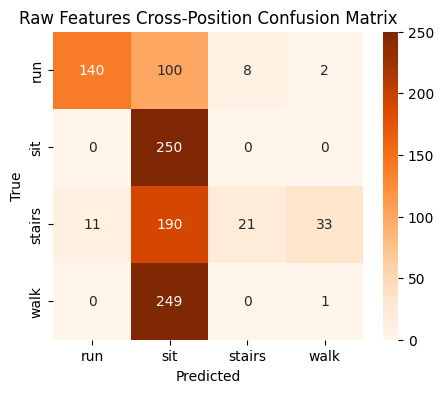


=== GFT FEATURES ===
Dataset built: 1005 windows, 100 timesteps, 6 features
Dataset built: 1005 windows, 100 timesteps, 6 features

=== Training K-Fold CV ===

--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---

=== Evaluating on Test Positions ===

=== GFT Features Cross-Position Classification Report ===
              precision    recall  f1-score   support

         run     0.8657    0.2320    0.3659       250
         sit     0.9804    1.0000    0.9901       250
      stairs     0.1056    0.0588    0.0756       255
        walk     0.4529    0.9800    0.6195       250

    accuracy                         0.5652      1005
   macro avg     0.6011    0.5677    0.5128      1005
weighted avg     0.5987    0.5652    0.5106      1005

Test Accuracy: 56.52%


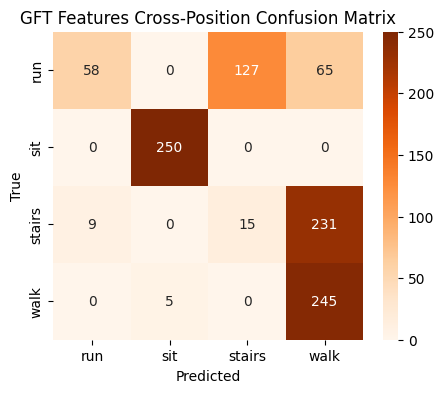

In [16]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)

    print("\n=== RAW FEATURES ===")
    cross_position_kfold(recordings, RAW_FEATURES, TRAIN_POSITIONS, TEST_POSITIONS, title="Raw Features Cross-Position")

    print("\n=== GFT FEATURES ===")
    cross_position_kfold(recordings, GFT_FEATURES, TRAIN_POSITIONS, TEST_POSITIONS, title="GFT Features Cross-Position")